#1. Import Depenedencies

In [2]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import densenet
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

#2. Initialize directories and models

In [3]:
# Paths to pre-trained models
ResNet_Path = '/content/chest_CT_SCAN-ResNet50(tuned).keras'
DenseNet_Path = '/content/chest_CT_SCAN-DenseNet201(tuned).keras'

# Load models
ResNet_model = tf.keras.models.load_model(ResNet_Path)
DenseNet_model = tf.keras.models.load_model(DenseNet_Path)

# Paths to directories
path_adeno = '/content/drive/MyDrive/Data/test/adenocarcinoma'
path_large = '/content/drive/MyDrive/Data/test/large.cell.carcinoma'
path_normal = '/content/drive/MyDrive/Data/test/normal'
path_squamous = '/content/drive/MyDrive/Data/test/squamous.cell.carcinoma'

# Class labels and mapping
keys = ['adeno', 'large', 'normal', 'squamous']
class_dict = {0: 'adeno', 1: 'large', 2: 'normal', 3: 'squamous'}

#3. Evaluate the models

In [4]:
# Store true and predicted labels separately for each model
true_labels = []
pred_labels_ensemble = []
pred_labels_resnet = []
pred_labels_densenet = []

# Evaluate models on test data
for path, key in zip([path_adeno, path_large, path_normal, path_squamous], keys):
    images = os.listdir(path)
    for image in images:
        my_image = load_img(path + '/' + image, target_size=(460, 460))
        my_image = img_to_array(my_image)
        my_image = my_image.reshape((1, 460, 460, 3))
        my_image_dense = my_image.copy()

        # ResNet prediction
        resnet_pred = ResNet_model.predict(my_image, verbose=0)
        resnet_class = np.argmax(resnet_pred)

        # DenseNet prediction
        my_image_dense = densenet.preprocess_input(my_image_dense)
        densenet_pred = DenseNet_model.predict(my_image_dense, verbose=0)
        densenet_class = np.argmax(densenet_pred)

        # Ensemble prediction (pick higher confidence max)
        if np.max(resnet_pred) >= np.max(densenet_pred):
            ensemble_class = resnet_class
        else:
            ensemble_class = densenet_class

        # Store true and predicted labels
        true_label = list(class_dict.keys())[list(class_dict.values()).index(key)]
        true_labels.append(true_label)
        pred_labels_resnet.append(resnet_class)
        pred_labels_densenet.append(densenet_class)
        pred_labels_ensemble.append(ensemble_class)

#4. Results visualization


ResNet Per-class Accuracy:
adeno_acc: 81.67%
large_acc: 74.51%
normal_acc: 98.15%
squamous_acc: 86.67%

DenseNet Per-class Accuracy:
adeno_acc: 75.00%
large_acc: 98.04%
normal_acc: 98.15%
squamous_acc: 90.00%

Ensemble Per-class Accuracy:
adeno_acc: 80.00%
large_acc: 92.16%
normal_acc: 98.15%
squamous_acc: 95.56%


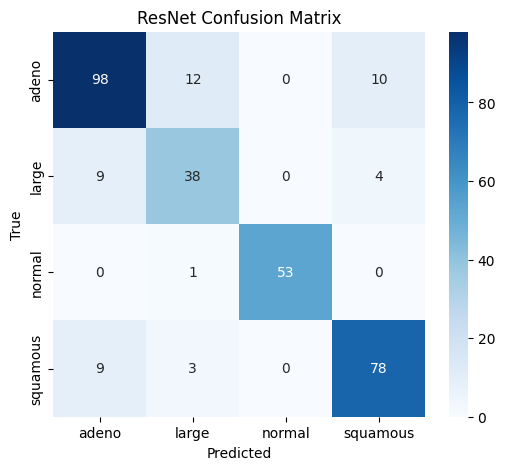

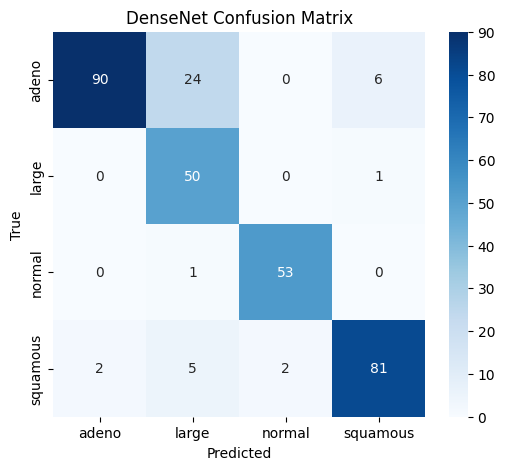

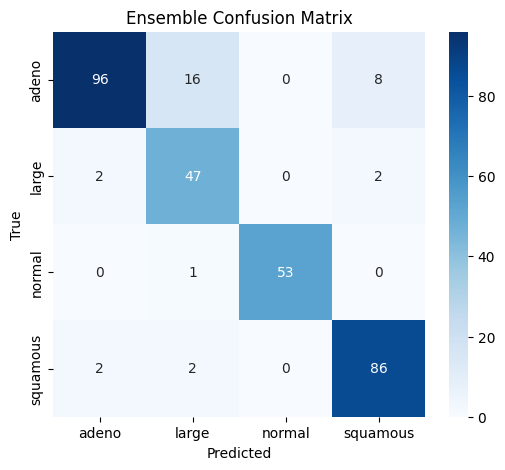


Overall Ensemble Metrics:
Accuracy: 0.8952
Precision (macro): 0.8920
Recall (macro): 0.9147
F1 Score (macro): 0.8979

Classification Report (Ensemble):
              precision    recall  f1-score   support

       adeno       0.96      0.80      0.87       120
       large       0.71      0.92      0.80        51
      normal       1.00      0.98      0.99        54
    squamous       0.90      0.96      0.92        90

    accuracy                           0.90       315
   macro avg       0.89      0.91      0.90       315
weighted avg       0.91      0.90      0.90       315



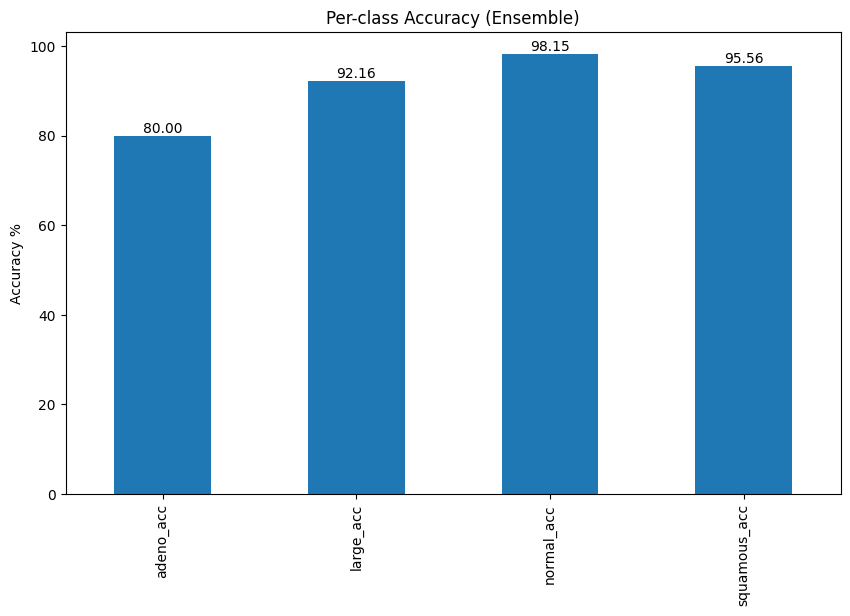

In [5]:
def per_class_accuracy(y_true, y_pred, model_name):
    """Compute per-class accuracy and confusion matrix"""
    cm = confusion_matrix(y_true, y_pred, labels=list(class_dict.keys()))
    acc_dict = {}
    for i, key in class_dict.items():
        correct = cm[i, i]
        total = cm[i].sum()
        acc = (correct / total) * 100 if total > 0 else 0
        acc_dict[f"{key}_acc"] = acc
    print(f"\n{model_name} Per-class Accuracy:")
    for k, v in acc_dict.items():
        print(f"{k}: {v:.2f}%")
    return acc_dict, cm

def plot_confusion_matrix(cm, model_name):
    """Plot confusion matrix heatmap"""
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_dict.values(),
                yticklabels=class_dict.values())
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Per-class accuracy
acc_resnet, cm_resnet = per_class_accuracy(true_labels, pred_labels_resnet, "ResNet")
acc_densenet, cm_densenet = per_class_accuracy(true_labels, pred_labels_densenet, "DenseNet")
acc_ensemble, cm_ensemble = per_class_accuracy(true_labels, pred_labels_ensemble, "Ensemble")

# Plot confusion matrices
plot_confusion_matrix(cm_resnet, "ResNet")
plot_confusion_matrix(cm_densenet, "DenseNet")
plot_confusion_matrix(cm_ensemble, "Ensemble")

# ------------------- OVERALL METRICS -------------------
print("\nOverall Ensemble Metrics:")
overall_accuracy = accuracy_score(true_labels, pred_labels_ensemble)
precision = precision_score(true_labels, pred_labels_ensemble, average='macro')
recall = recall_score(true_labels, pred_labels_ensemble, average='macro')
f1 = f1_score(true_labels, pred_labels_ensemble, average='macro')

print(f"Accuracy: {overall_accuracy:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1 Score (macro): {f1:.4f}")

print("\nClassification Report (Ensemble):")
print(classification_report(true_labels, pred_labels_ensemble, target_names=class_dict.values()))

df_acc = pd.DataFrame(acc_ensemble.values(), index=acc_ensemble.keys(), columns=['ACCURACY %'])
ax = df_acc.plot(kind='bar', stacked=True, figsize=(10, 6), ylabel='Accuracy %', legend=None)
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f")
plt.title("Per-class Accuracy (Ensemble)")
plt.show()